In [117]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

pd.set_option('display.max_columns', None)

In [2]:
prev_lives_train = pd.read_csv('../data/previous_lives_training_data.csv', index_col=0)
prev_lives_test = pd.read_csv('../data/previous_lives_test_data.csv', index_col=0)

registration_train = pd.read_csv('../data/registration_data_training.csv', index_col=0)
registration_test = pd.read_csv('../data/registration_data_test.csv', index_col=0)

prev_lives_train.shape, prev_lives_test.shape, registration_train.shape, registration_test.shape

((84941, 10), (86113, 10), (50000, 29), (50000, 28))

In [3]:
registration_train.head(3)

,registration_time_utc,registration_platform_specific,registration_country,registration_store,registration_season_day,registration_channel_detailed,registration_device_type,registration_device_manufacturer,session_count,playtime,number_of_devices_used,total_match_played_count,total_match_won_count,total_match_watched_count,transaction_count_iap,transaction_count_rewarded_video,tokens_spent,tokens_stash,tokens_bought,rests_stash,rests_spent,treatments_spent,morale_spent,money_stash,avg_stars_top_11_players,avg_stars_top_3_players,avg_age_top_11_players,training_count,days_active_first_28_days_after_registration
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,2024-05-25 01:26:48.000,iOS Phone,France,AppStore,7,Organic,Phone,Apple,1,141062,1,2,1,0,0,0,0,114,0,524,0,0,0,1066076772,4.721867,5.451511,22.0,0,0
7,2024-06-14 20:09:31.000,Android Phone,Turkey,GooglePlay,27,Unknown,Phone,Xiaomi,1,521754,1,0,0,0,0,0,0,157,0,962,0,0,0,1224446429,4.911067,5.303822,22.0,1,0
13,2024-05-31 09:06:51.000,Android Phone,Belarus,GooglePlay,13,Organic,Phone,Xiaomi,2,1703183,1,0,0,0,0,0,20,232,0,829,0,0,0,1221792142,5.018146,5.746889,24.0,3,0


In [4]:
prev_lives_train.head(3)

,registration_date,registration_season_day,registration_country,registration_channel_detailed,registration_store,registration_platform_specific,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime
user_id,,,,,,,,,,
5,2022-04-21,26,France,Organic,AppStore,iOS Phone,False,1,0,False
5,2023-05-07,15,France,Paid,AppStore,iOS Phone,False,18,0,True
7,2022-04-06,11,Turkey,Organic,AppStore,iOS Phone,False,21,0,True


In [5]:
np.intersect1d(registration_train.columns, prev_lives_train.columns)

array(['registration_channel_detailed', 'registration_country',
       'registration_platform_specific', 'registration_season_day',
       'registration_store'], dtype=object)

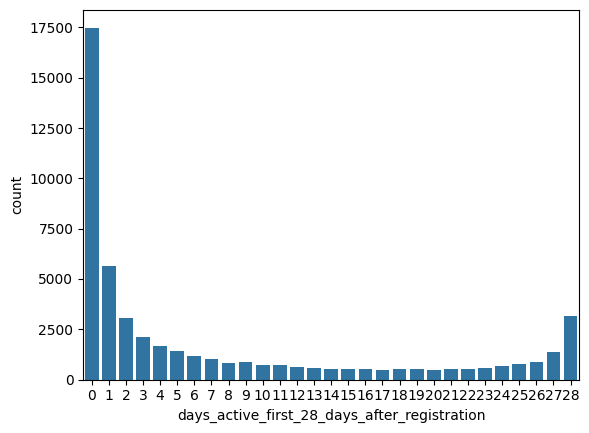

In [104]:
# target variable distribution
sns.countplot(x='days_active_first_28_days_after_registration', data=registration_train)
plt.show()

Comment: Skewed and zero-inflated distribution of target variable; "smiling" curve indicates that there are low-frequency and hight frequency users.

In [7]:
registration_train.value_counts('days_active_first_28_days_after_registration', normalize=True).sort_values(ascending=False)[:10]

days_active_first_28_days_after_registration
0     0.34982
1     0.11284
28    0.06368
2     0.06090
3     0.04276
4     0.03296
5     0.02806
27    0.02740
6     0.02330
7     0.02034
Name: proportion, dtype: float64

### Data Cleaning and Preprocessing

In [8]:
import sys
import os
current_dir = os.getcwd() 
project_root = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(project_root)

from src.check_values_train_test import check_values
from config import nominal_features_registration, nominal_features_prev_lives


print("======= Registration data:")
check_values(['../data/registration_data_training.csv', '../data/registration_data_test.csv'], nominal_features_registration)
print("\n======= Previous lives data:")
check_values(['../data/previous_lives_training_data.csv', '../data/previous_lives_test_data.csv'], nominal_features_prev_lives)
print("\n======= Intersection of registration and previous lives data:")
check_values(['../data/registration_data_training.csv', '../data/registration_data_test.csv', '../data/previous_lives_training_data.csv', '../data/previous_lives_test_data.csv'], np.intersect1d(nominal_features_registration, nominal_features_prev_lives))

======= Registration data:

Checking feature: registration_platform_specific
✓ Values match
Unique values: ['Android Phone', 'Android Tablet', 'UniversalWindows PC', 'WebGL FB Canvas', 'WebGL TE Site', 'iOS Phone', 'iOS Tablet']

Checking feature: registration_country
❌ Values mismatch detected!
Values missing in dataset 0 (../data/registration_data_training.csv): {'Madagascar', 'Monaco', 'Cook Islands', 'Bermuda', 'Dominica', 'Saint Martin', 'Curacao', 'San Marino', 'Virgin Islands, British', 'Burundi', 'Timor-Leste', 'Antigua and Barbuda', 'Lesotho', 'Bahamas', 'Seychelles'}
Values missing in dataset 1 (../data/registration_data_test.csv): {'Cayman Islands', 'New Caledonia', 'Unknown', 'Fiji', 'Guinea-Bissau', 'Isle of Man', 'Mayotte', 'Saint Lucia', 'Comoros', 'Djibouti', 'Sierra Leone', 'French Polynesia'}

Checking feature: registration_store
✓ Values match
Unique values: ['AppStore', 'Catappult', 'Facebook', 'GooglePlay', 'GooglePlayForPC', 'Huawei', 'WindowsStore']

Checking fea

Comment: we can see that the registration_country has a lot of mismatched values across different datasets. For this reason, we can examine the distribution of country values and replace all countries that are rare in the datasets with the value "Other"
This will be added in the data_cleaning.py script

In [9]:
df_concatenated_country = pd.concat([
    df.filter(['registration_country']) 
    for df in [registration_train, registration_test, prev_lives_train, prev_lives_test]
])
df_concatenated_country.value_counts(normalize=True)[:15]


registration_country
Indonesia               0.225402
Turkey                  0.087787
Brazil                  0.064260
Germany                 0.043036
France                  0.034307
United Kingdom          0.033351
Thailand                0.029171
Spain                   0.028452
Poland                  0.027375
Italy                   0.026851
Malaysia                0.021664
United States           0.018207
Argentina               0.017284
Romania                 0.016554
Greece                  0.016119
Name: proportion, dtype: float64

Comment: As assumed, we can see that the country values are distributed very unevenly, with only a few countries having a significant number of users. We can replace all countries that are rare in the datasets with the value "Other". Strangely, the country "United States" is not in the top 10 most frequent countries. Also, Indonesia is the most frequent country, which is interesting.

In [10]:
df_concatenated_country.value_counts().describe()

count      206.000000
mean      1315.796117
std       4960.620127
min          1.000000
25%         16.000000
50%        132.000000
75%        703.500000
max      61096.000000
Name: count, dtype: float64

In [11]:
df_concatenated_country.value_counts(normalize=True).values[:50].sum()

np.float64(0.9194256495015753)

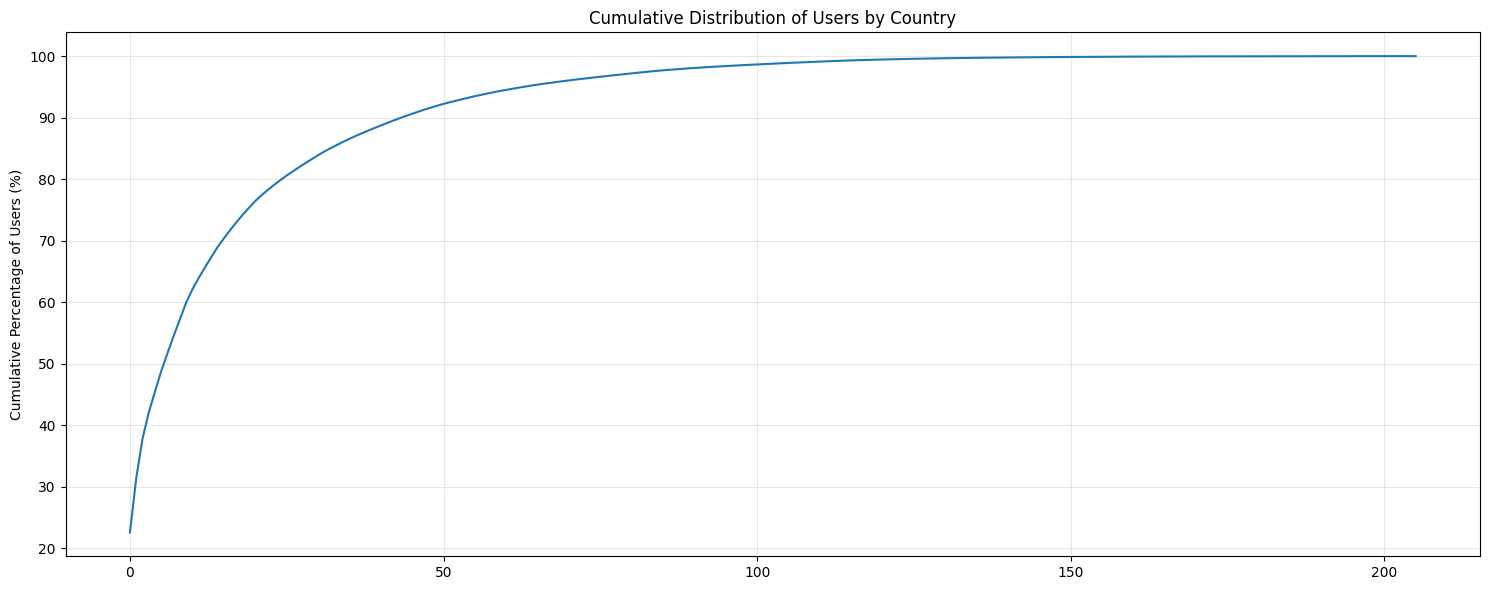

In [12]:
value_counts = df_concatenated_country.value_counts(normalize=True)

cumulative_counts = (value_counts.cumsum() * 100)

# plot
plt.figure(figsize=(15, 6))
sns.lineplot(x=range(len(cumulative_counts)), y=cumulative_counts.values)
  
plt.ylabel('Cumulative Percentage of Users (%)')
plt.title('Cumulative Distribution of Users by Country')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
percentage_threshold = 95
threshold = value_counts[cumulative_counts <= percentage_threshold].values[-1]
filtered_countries = value_counts[value_counts > threshold]
cumulative_counts_filtered = cumulative_counts[cumulative_counts <= percentage_threshold]
print(f'{threshold=}')
print(f'Number of countries that exceed the threshold: {len(cumulative_counts_filtered)}')
print(f'{cumulative_counts_filtered.iloc[-1]:.2f}% of users covered by first {len(cumulative_counts_filtered)} countries', )

threshold=np.float64(0.0017745541478819719)
Number of countries that exceed the threshold: 63
94.88% of users covered by first 63 countries


We will save this threshold in the config.py file as country_threshold, so all countries with a frequency lower than this threshold will be replaced with "Other".

In [113]:
# checking if the data cleaning script works (after running it using the src/data_cleaning.py script)
cleaned_registration_train = pd.read_csv('../cleaned_data/registration_data_training.csv', index_col=0)
cleaned_registration_train.registration_country.value_counts()

registration_country
Indonesia     12018
Turkey         4472
Brazil         3067
Other          2723
Germany        2130
              ...  
Ireland          97
Uruguay          95
Kazakhstan       95
Albania          92
Finland          78
Name: count, Length: 63, dtype: int64

Comment: We can see that the "Other" category now has a much higher frequency. This is not surprising, as we replaced all countries with a frequency lower than the threshold with "Other". However, we can see that it is now the 4th most frequent country, which is not ideal because it is not very informative. We can try to improve this by using continent as additional information. This will be done later.

We can repeat the same process for registration_device_manufacturer column

In [247]:
df_registration_device_manufacturer = pd.concat([
    df.filter(['registration_device_manufacturer']) 
    for df in [registration_train, registration_test, prev_lives_train, prev_lives_test]
])
df_registration_device_manufacturer.value_counts(normalize=True)[:15]

registration_device_manufacturer
Apple                               0.254641
samsung                             0.253999
Xiaomi                              0.196668
OPPO                                0.062635
vivo                                0.044661
realme                              0.040175
motorola                            0.031172
HUAWEI                              0.023361
INFINIX                             0.017239
INFINIX MOBILITY LIMITED            0.011572
HONOR                               0.009873
TECNO                               0.007500
Google                              0.006382
OnePlus                             0.005377
LENOVO                              0.003491
Name: proportion, dtype: float64

In [248]:
df_registration_device_manufacturer.describe()

,registration_device_manufacturer
count,96528
unique,242
top,Apple
freq,24580


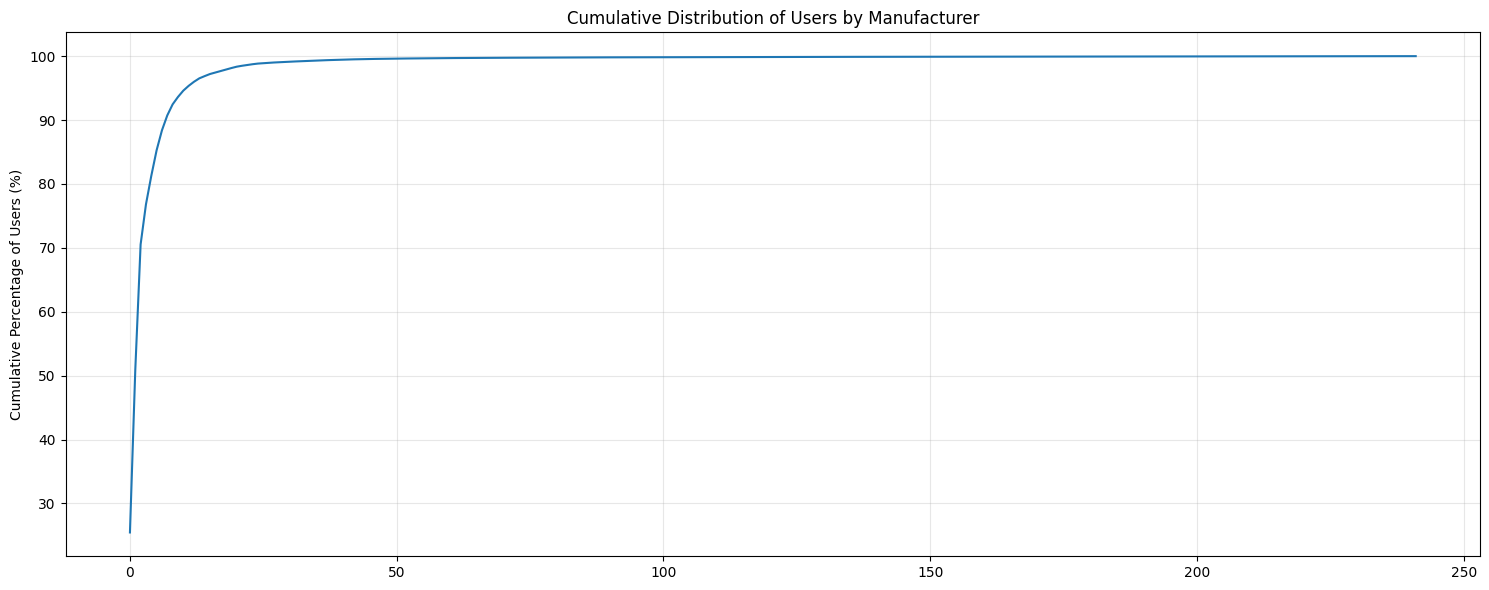

In [251]:
value_counts = df_registration_device_manufacturer.value_counts(normalize=True)

cumulative_counts = (value_counts.cumsum() * 100)

# plot
plt.figure(figsize=(15, 6))
sns.lineplot(x=range(len(cumulative_counts)), y=cumulative_counts.values)
  
plt.ylabel('Cumulative Percentage of Users (%)')
plt.title('Cumulative Distribution of Users by Manufacturer')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Comment: Here, the situation is even more skewed than with the country column. We can see that the manufacturers are distributed very unevenly, with only a few manufacturers having a significant number of users. We can map all manufacturers with a frequency lower than the threshold (say 1%) with "Other". We can also add this to the config.py file as manufacturer_threshold.

In [249]:
df_registration_device_manufacturer.value_counts(normalize=True)[:15]

registration_device_manufacturer
Apple                               0.254641
samsung                             0.253999
Xiaomi                              0.196668
OPPO                                0.062635
vivo                                0.044661
realme                              0.040175
motorola                            0.031172
HUAWEI                              0.023361
INFINIX                             0.017239
INFINIX MOBILITY LIMITED            0.011572
HONOR                               0.009873
TECNO                               0.007500
Google                              0.006382
OnePlus                             0.005377
LENOVO                              0.003491
Name: proportion, dtype: float64

Comment: We can see that we should map "INFINIX" and "INFINIX MOBILITY LIMITED" to "INFINIX".
Below that, all manufacturers have a very low number of users (less than 1%), so we can map all of them to "Other".
We can also add this to the config.py file as manufacturer_threshold.

In [208]:
# checking if the data cleaning script works (after running it using the src/data_cleaning.py script)
cleaned_registration_train = pd.read_csv('../cleaned_data/registration_data_training.csv', index_col=0)
cleaned_registration_train.registration_device_manufacturer.value_counts(normalize=True)

registration_device_manufacturer
Apple       0.24136
samsung     0.23630
Xiaomi      0.19370
Other       0.10918
OPPO        0.06238
vivo        0.04596
realme      0.04144
motorola    0.02928
HUAWEI      0.02278
INFINIX     0.01762
Name: proportion, dtype: float64

In [210]:
# check values after cleaning

print("======= Registration data:")
check_values(['../cleaned_data/registration_data_training.csv', '../cleaned_data/registration_data_test.csv'], nominal_features_registration)
print("\n======= Previous lives data:")
check_values(['../cleaned_data/previous_lives_training_data.csv', '../cleaned_data/previous_lives_test_data.csv'], nominal_features_prev_lives)


======= Registration data:

Checking feature: registration_platform_specific
✓ Values match
Unique values: ['Android Phone', 'Android Tablet', 'UniversalWindows PC', 'WebGL FB Canvas', 'WebGL TE Site', 'iOS Phone', 'iOS Tablet']

Checking feature: registration_country
✓ Values match
Unique values: ['Algeria', 'Argentina', 'Australia', 'Austria', 'Azerbaijan', 'Belgium', 'Brazil', 'Canada', 'Chile', 'Colombia', 'Croatia', 'Czech Republic', 'Denmark', 'Egypt', 'France', 'Germany', 'Greece', 'India', 'Indonesia', 'Israel', 'Italy', 'Malaysia', 'Mexico', 'Morocco', 'Netherlands', 'Nigeria', 'Other', 'Peru', 'Poland', 'Portugal', 'Romania', 'Saudi Arabia', 'Serbia', 'Slovakia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'Turkey', 'Ukraine', 'United Kingdom', 'United States', 'Vietnam']

Checking feature: registration_store
✓ Values match
Unique values: ['AppStore', 'Catappult', 'Facebook', 'GooglePlay', 'GooglePlayForPC', 'Huawei', 'WindowsStore']

Checking feature: regis

### Label encoding

Let's check the label encoded data as a result of running the src/label_encoding.py script.

In [198]:
prev_lives_train_labeled = pd.read_csv('../cleaned_data/previous_lives_training_data_labeled.csv', index_col=0)
prev_lives_test_labeled = pd.read_csv('../cleaned_data/previous_lives_test_data_labeled.csv', index_col=0)

registration_train_labeled = pd.read_csv('../cleaned_data/registration_data_training_labeled.csv', index_col=0)
registration_test_labeled = pd.read_csv('../cleaned_data/registration_data_test_labeled.csv', index_col=0)

In [199]:
prev_lives_train_labeled.head()

,registration_date,registration_season_day,registration_country,registration_channel_detailed,registration_store,registration_platform_specific,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime
user_id,,,,,,,,,,
5,2022-04-21,26,19,0,0,5,0,1,0,0
5,2023-05-07,15,19,1,0,5,0,18,0,1
7,2022-04-06,11,55,0,0,5,0,21,0,1
7,2023-02-06,9,55,0,3,0,0,2,0,0
7,2023-05-28,8,55,2,3,0,0,1,0,0


In [193]:
prev_lives_train.head()

,registration_date,registration_season_day,registration_country,registration_channel_detailed,registration_store,registration_platform_specific,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime,year,week,month,dayofweek,weekend
user_id,,,,,,,,,,,,,,,
5,2022-04-21,26,France,Organic,AppStore,iOS Phone,False,1,0,False,2022,16,4,3,0
5,2023-05-07,15,France,Paid,AppStore,iOS Phone,False,18,0,True,2023,18,5,6,1
7,2022-04-06,11,Turkey,Organic,AppStore,iOS Phone,False,21,0,True,2022,14,4,2,0
7,2023-02-06,9,Turkey,Organic,GooglePlay,Android Phone,False,2,0,False,2023,6,2,0,0
7,2023-05-28,8,Turkey,Unknown,GooglePlay,Android Phone,False,1,0,False,2023,21,5,6,1


In [194]:
registration_train_labeled.head()

,registration_time_utc,registration_platform_specific,registration_country,registration_store,registration_season_day,registration_channel_detailed,registration_device_type,registration_device_manufacturer,session_count,playtime,number_of_devices_used,total_match_played_count,total_match_won_count,total_match_watched_count,transaction_count_iap,transaction_count_rewarded_video,tokens_spent,tokens_stash,tokens_bought,rests_stash,rests_spent,treatments_spent,morale_spent,money_stash,avg_stars_top_11_players,avg_stars_top_3_players,avg_age_top_11_players,training_count,days_active_first_28_days_after_registration
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,2024-05-25 01:26:48.000,5,19,0,7,0,1,0,1,141062,1,2,1,0,0,0,0,114,0,524,0,0,0,1066076772,4.721867,5.451511,22.0,0,0
7,2024-06-14 20:09:31.000,0,55,3,27,2,1,5,1,521754,1,0,0,0,0,0,0,157,0,962,0,0,0,1224446429,4.911067,5.303822,22.0,1,0
13,2024-05-31 09:06:51.000,0,39,3,13,0,1,5,2,1703183,1,0,0,0,0,0,20,232,0,829,0,0,0,1221792142,5.018146,5.746889,24.0,3,0
23,2024-05-31 04:00:33.000,0,24,3,13,1,1,3,4,3181700,1,3,2,1,0,0,79,8,0,180,39,12,9,928112709,5.827455,6.692578,22.0,7,1
25,2024-06-15 19:56:05.000,5,17,0,28,0,1,0,5,5866921,1,1,0,1,0,0,77,70,0,209,80,0,2,326553498,5.340412,5.775289,24.0,6,3


In [142]:
registration_train.head()

,registration_time_utc,registration_platform_specific,registration_country,registration_store,registration_season_day,registration_channel_detailed,registration_device_type,registration_device_manufacturer,session_count,playtime,number_of_devices_used,total_match_played_count,total_match_won_count,total_match_watched_count,transaction_count_iap,transaction_count_rewarded_video,tokens_spent,tokens_stash,tokens_bought,rests_stash,rests_spent,treatments_spent,morale_spent,money_stash,avg_stars_top_11_players,avg_stars_top_3_players,avg_age_top_11_players,training_count,days_active_first_28_days_after_registration
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,2024-05-25 01:26:48.000,iOS Phone,France,AppStore,7,Organic,Phone,Apple,1,141062,1,2,1,0,0,0,0,114,0,524,0,0,0,1066076772,4.721867,5.451511,22.0,0,0
7,2024-06-14 20:09:31.000,Android Phone,Turkey,GooglePlay,27,Unknown,Phone,Xiaomi,1,521754,1,0,0,0,0,0,0,157,0,962,0,0,0,1224446429,4.911067,5.303822,22.0,1,0
13,2024-05-31 09:06:51.000,Android Phone,Belarus,GooglePlay,13,Organic,Phone,Xiaomi,2,1703183,1,0,0,0,0,0,20,232,0,829,0,0,0,1221792142,5.018146,5.746889,24.0,3,0
23,2024-05-31 04:00:33.000,Android Phone,Indonesia,GooglePlay,13,Paid,Phone,OPPO,4,3181700,1,3,2,1,0,0,79,8,0,180,39,12,9,928112709,5.827455,6.692578,22.0,7,1
25,2024-06-15 19:56:05.000,iOS Phone,Egypt,AppStore,28,Organic,Phone,Apple,5,5866921,1,1,0,1,0,0,77,70,0,209,80,0,2,326553498,5.340412,5.775289,24.0,6,3


In [144]:
# check values after label encoding

print("======= Registration data:")
check_values(['../cleaned_data/registration_data_training_labeled.csv', '../cleaned_data/registration_data_test_labeled.csv'], nominal_features_registration)
print("\n======= Previous lives data:")
check_values(['../cleaned_data/previous_lives_training_data_labeled.csv', '../cleaned_data/previous_lives_test_data_labeled.csv'], nominal_features_prev_lives)
print("\n======= Intersection of registration and previous lives data:")
check_values(['../cleaned_data/registration_data_training_labeled.csv', '../cleaned_data/registration_data_test_labeled.csv', '../cleaned_data/previous_lives_training_data_labeled.csv', '../cleaned_data/previous_lives_test_data_labeled.csv'], np.intersect1d(nominal_features_registration, nominal_features_prev_lives))


======= Registration data:

Checking feature: registration_platform_specific
✓ Values match
Unique values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

Checking feature: registration_country
✓ Values match
Unique values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52)

Comment: The encoded data looks good. We can see that for the registration_store, we have a single value that can only be found in past lives data. We will ignore this for now.

### Previous lives data - feature engineering

Now let's check the previous lives data. We want to merge it with the registration data, but first we need to do some **feature engineering** in order use the information from all columns in the previous lives data.

In [124]:
prev_lives_train.head()

,registration_date,registration_season_day,registration_country,registration_channel_detailed,registration_store,registration_platform_specific,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime
user_id,,,,,,,,,,
5,2022-04-21,26,France,Organic,AppStore,iOS Phone,False,1,0,False
5,2023-05-07,15,France,Paid,AppStore,iOS Phone,False,18,0,True
7,2022-04-06,11,Turkey,Organic,AppStore,iOS Phone,False,21,0,True
7,2023-02-06,9,Turkey,Organic,GooglePlay,Android Phone,False,2,0,False
7,2023-05-28,8,Turkey,Unknown,GooglePlay,Android Phone,False,1,0,False


In [100]:
most_common_user_id = prev_lives_train.index.value_counts().index[0]
prev_lives_train[prev_lives_train.index == most_common_user_id].sort_values(by='registration_date')

,registration_date,registration_season_day,registration_country,registration_channel_detailed,registration_store,registration_platform_specific,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime
user_id,,,,,,,,,,
201487,2022-04-02,7,Poland,Organic,GooglePlay,Android Phone,False,1,0,False
201487,2022-09-05,23,Poland,Paid,GooglePlay,Android Phone,False,4,0,False
201487,2022-11-11,6,Poland,Paid,GooglePlay,Android Phone,True,38,11,True
201487,2023-04-22,28,Poland,Organic,GooglePlay,Android Phone,False,1,0,False
201487,2023-06-22,5,Poland,Unknown,GooglePlay,Android Phone,False,1,0,False
201487,2023-09-22,13,Poland,Organic,GooglePlay,Android Phone,False,1,0,False
201487,2023-12-31,1,Poland,Organic,GooglePlay,Android Phone,False,2,0,False


- The dataset past lives contains a lot of information about the user's activity in the game, which we can use to create new features.
- For **registration_date**, we can first extract the year, month, week, day of week, day of month and whether it is a weekend from the registration_date column. Then we can use these to calculate number of unique values for each of them, as well as the most common value.
- We can also use registration_date to calculate first registration date and last registration date.
- For **nominal** features like registration_country, registration_channel_detailed, registration_store, registration_platform_specific, we can calculate the number of unique values.
- For **binary** features like is_payer_lifetime, is_rewarded_video_watcher_lifetime, we can calculate the number of True values.
- For **numerical** features like days_active_lifetime, transaction_count_iap_lifetime, we can calculate the sum, mean, max, min, std of the values.
- All of this is done in the **feature_engineering.py** script.

In [102]:
# prev lives data after transformation
prev_lives_train_transformed = pd.read_csv('/root/projects/ds_chlg/Data Science Challenge/Data Science/aggregated_data/aggregated_previous_lives_test_data.csv', index_col=0)
prev_lives_train_transformed.head()

,year_nunique,year_mode_value,month_nunique,month_mode_value,week_nunique,week_mode_value,dayofweek_nunique,dayofweek_mode_value,dayofmonth_nunique,dayofmonth_mode_value,weekend_nunique,weekend_mode_value,first_registration_date_prev_lives,last_registration_date_prev_lives,registration_country_nunique,registration_channel_detailed_nunique,registration_store_nunique,registration_platform_specific_nunique,is_payer_lifetime_sum,is_rewarded_video_watcher_lifetime_sum,days_active_lifetime_sum,days_active_lifetime_mean,days_active_lifetime_max,days_active_lifetime_min,days_active_lifetime_std,transaction_count_iap_lifetime_sum,transaction_count_iap_lifetime_mean,transaction_count_iap_lifetime_max,transaction_count_iap_lifetime_min,transaction_count_iap_lifetime_std
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300004,2,2022,1,4,2,14,2,2,2,6,1,0,2022-04-20,2023-04-06,2,2,1,1,0,1,6,3.0,5,1,2.828427,0,0.0,0,0,0.0
300006,1,2022,1,6,1,23,1,3,1,9,1,0,2022-06-09,2022-06-09,1,1,1,1,0,1,69,69.0,69,69,NaN,0,0.0,0,0,NaN
300012,2,2022,2,5,2,21,2,1,2,13,1,0,2022-05-25,2023-06-13,1,1,1,1,0,1,100,50.0,96,4,65.053824,0,0.0,0,0,0.0
300022,1,2023,1,2,1,6,1,2,1,8,1,0,2023-02-08,2023-02-08,1,1,1,1,0,0,5,5.0,5,5,NaN,0,0.0,0,0,NaN
300031,1,2023,1,4,1,16,1,1,1,18,1,0,2023-04-18,2023-04-18,1,1,1,1,0,1,17,17.0,17,17,NaN,0,0.0,0,0,NaN


Note: NaN values are handled later.

### Previous lives data and registration data mergeing and feature engineering

- We can now merge the previous lives data with the registration data using user_id.
- After we performe merging, we can create additional features:
    - recency: number of days since the last registration
    - age: number of days since the first registration
    - frequency: mean number of days between registrations
    - match win rate
    - avg tokens spent per session
    - inactive days
    - registration frequency
- All of this is done in the **feature_engineering.py** script.

In [105]:
# checking the merged data
df_merged_data_train = pd.read_csv('/root/projects/ds_chlg/Data Science Challenge/Data Science/aggregated_data/merged_data_training.csv', index_col=0)
df_merged_data_train.head()

,registration_platform_specific,registration_country,registration_store,registration_season_day,registration_channel_detailed,registration_device_type,registration_device_manufacturer,session_count,playtime,number_of_devices_used,total_match_played_count,total_match_won_count,total_match_watched_count,transaction_count_iap,transaction_count_rewarded_video,tokens_spent,tokens_stash,tokens_bought,rests_stash,rests_spent,treatments_spent,morale_spent,money_stash,avg_stars_top_11_players,avg_stars_top_3_players,avg_age_top_11_players,training_count,days_active_first_28_days_after_registration,year,week,month,dayofweek,dayofmonth,weekend,year_nunique,year_mode_value,month_nunique,month_mode_value,week_nunique,week_mode_value,dayofweek_nunique,dayofweek_mode_value,dayofmonth_nunique,dayofmonth_mode_value,weekend_nunique,weekend_mode_value,registration_country_nunique,registration_channel_detailed_nunique,registration_store_nunique,registration_platform_specific_nunique,is_payer_lifetime_sum,is_rewarded_video_watcher_lifetime_sum,days_active_lifetime_sum,days_active_lifetime_mean,days_active_lifetime_max,days_active_lifetime_min,days_active_lifetime_std,transaction_count_iap_lifetime_sum,transaction_count_iap_lifetime_mean,transaction_count_iap_lifetime_max,transaction_count_iap_lifetime_min,transaction_count_iap_lifetime_std,recency_days,age_days,frequency,match_win_rate,avg_tokens_spent_per_session,inactive_days,registration_frequency_days
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,5,19,0,7,0,1,0,1,141062,1,2,1,0,0,0,0,114,0,524,0,0,0,1066076772,4.721867,5.451511,22.0,0,0,2024,21,5,5,25,1,2,2022,2,4,2,16,2,3,2,7,2,0,1,2,1,1,0,1,19,9.5,18,1,12.020815,0,0.0,0,0,0.0,384,765,9.5,0.500000,0.00,746,382.5
7,0,55,3,27,2,1,5,1,521754,1,0,0,0,0,0,0,157,0,962,0,0,0,1224446429,4.911067,5.303822,22.0,1,0,2024,24,6,4,14,0,2,2023,3,2,3,6,3,0,2,6,2,0,1,2,2,2,0,1,24,8.0,21,1,11.269428,0,0.0,0,0,0.0,383,800,12.0,0.000000,0.00,776,400.0
13,0,39,3,13,0,1,5,2,1703183,1,0,0,0,0,0,20,232,0,829,0,0,0,1221792142,5.018146,5.746889,24.0,3,0,2024,22,5,4,31,0,2,2022,2,8,2,33,2,1,2,17,1,0,1,1,1,1,0,1,222,111.0,221,1,155.563492,0,0.0,0,0,0.0,288,591,111.0,0.000000,10.00,369,295.5
23,0,24,3,13,1,1,3,4,3181700,1,3,2,1,0,0,79,8,0,180,39,12,9,928112709,5.827455,6.692578,22.0,7,1,2024,22,5,4,31,0,1,2023,1,8,1,35,1,2,1,30,1,0,1,1,1,1,0,1,2,2.0,2,2,0.000000,0,0.0,0,0,0.0,275,275,2.0,0.666667,19.75,273,275.0
25,5,17,0,28,0,1,0,5,5866921,1,1,0,1,0,0,77,70,0,209,80,0,2,326553498,5.340412,5.775289,24.0,6,3,2024,24,6,5,15,1,2,2022,1,8,2,33,2,1,2,15,1,0,1,2,1,1,0,1,19,9.5,18,1,12.020815,0,0.0,0,0,0.0,305,661,9.5,0.000000,15.40,642,330.5


In [107]:
df_merged_data_train.shape

(50000, 69)

### Model training

- I have decided to train two types of models for this task:
    - Plain XGBoost regressor with different objectives (reg:tweedie, reg:absoluteerror, count:poisson). Eventually, reg:absoluteerror is the best performing model (which is not surprising since the evaluation metric is MAE).
    - A two-stage model with a binary classifier that models the probability of being active in the next 28 days (similar to churn prediction) and a regressor that models the number of active days for active users. For both binary classifier and regressor, I have used XGBoost algorithm.
- XGBoost is used because it is very good for columnar data, and it performs feature selection as a by-product of training.
- For both models, I have used **5-fold cross-validation** to evaluate the performance. The dataset is created using src/stratified_kfold.py script. Stratified k-fold is used to ensure that the distribution of the target variable is the same in each fold. Also, the dataset is shuffled before splitting into folds.
- First model is trained using src/train.py script, and the second one is trained using src/train_two_stage.py script.

In [147]:
import sys
import os
current_dir = os.getcwd() 
project_root = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(project_root)
from src.train import round_and_clip

import xgboost as xgb
from sklearn import metrics

In [148]:
# 1) Plain XGBoost regressor
# training the model with the following parameters: {'objective': 'reg:absoluteerror', 'eta': 0.08, 'gamma': 0.5, 'max_depth': 6, 'reg_lambda': 0.01, 'min_child_weight': 3}
df_train = pd.read_csv('/root/projects/ds_chlg/Data Science Challenge/Data Science/aggregated_data/merged_data_training.csv', index_col=0)
df_test = pd.read_csv('/root/projects/ds_chlg/Data Science Challenge/Data Science/aggregated_data/merged_data_test.csv', index_col=0)

target = 'days_active_first_28_days_after_registration'
features = [f for f in df_train.columns if f not in (target)]

X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
model = xgb.XGBRegressor(
        n_jobs=-1,
        objective='reg:absoluteerror',
        eta=0.08,
        gamma=0.5,
        max_depth=6,
        reg_lambda=0.01,
        min_child_weight=3
    )
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
preds_clipped = round_and_clip(y_pred)
preds_clipped_train = round_and_clip(y_train_pred)

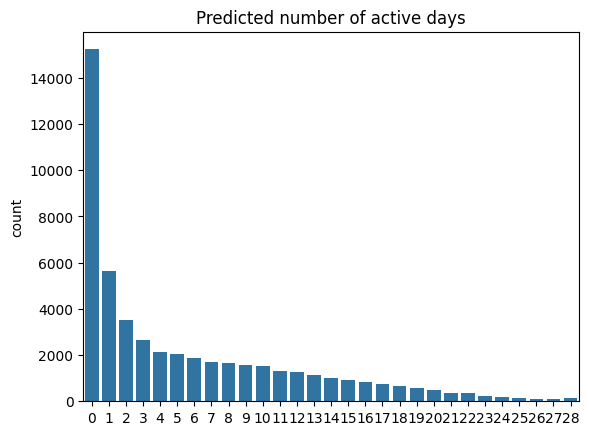

In [150]:
# plot the distribution of the predicted values
sns.countplot(x=preds_clipped_train.astype(int))
plt.title("Predicted number of active days")
plt.show()

In [151]:
# MAE on training set
metrics.mean_absolute_error(y_train, preds_clipped_train)

np.float64(5.07148)

In [ ]:
# 2) Two-stage model    
# training the regression model with the following parameters:  {'objective': 'reg:absoluteerror', 'eta': 0.08, 'gamma': 0.5, 'max_depth': 6, 'subsample': 1.0, 'min_child_weight': 5}
df_train = pd.read_csv('/root/projects/ds_chlg/Data Science Challenge/Data Science/aggregated_data/merged_data_training.csv', index_col=0)
df_test = pd.read_csv('/root/projects/ds_chlg/Data Science Challenge/Data Science/aggregated_data/merged_data_test.csv', index_col=0)

target = 'days_active_first_28_days_after_registration'
features = [f for f in df_train.columns if f not in (target)]

X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]


def train_simple_two_stage(X_train, X_test, y_train):
    y_train_binary = (y_train > 0).astype(int)
    
    # Stage 1: Train binary classifier
    clf_model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=100,
        max_depth=6
    )
    clf_model.fit(X_train, y_train_binary)
    
    # Get probabilities for both train and test
    train_pred_proba = clf_model.predict_proba(X_train)[:, 1]
    test_pred_proba = clf_model.predict_proba(X_test)[:, 1]
    
    threshold = 0.5
    train_pos_mask = train_pred_proba > threshold
    test_pos_mask = test_pred_proba > threshold
    
    # Stage 2: Train regressor on positive samples
    reg_model = xgb.XGBRegressor(
        objective='reg:absoluteerror',
        n_estimators=100,
        max_depth=6
    )
    reg_model.fit(X_train[train_pos_mask], y_train[train_pos_mask])
    
    train_final = np.zeros(len(X_train), dtype=float)
    test_final = np.zeros(len(X_test), dtype=float)
    
    if train_pos_mask.any():
        train_final[train_pos_mask] = reg_model.predict(X_train[train_pos_mask])
    if test_pos_mask.any():
        test_final[test_pos_mask] = reg_model.predict(X_test[test_pos_mask])
    
    train_final = round_and_clip(train_final)
    test_final = round_and_clip(test_final)
    
    return train_final, test_final, clf_model, reg_model

train_preds, test_preds, clf_model, reg_model = train_simple_two_stage(X_train, X_test, y_train)

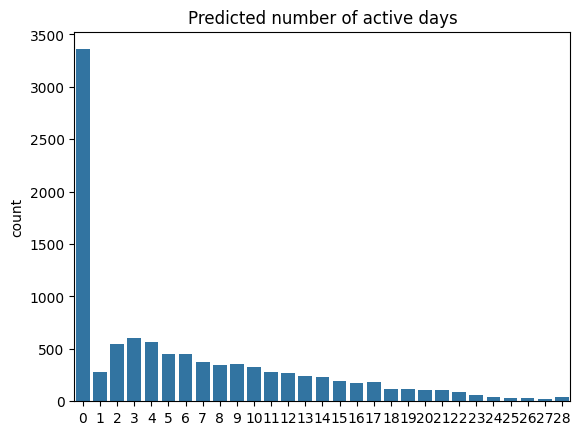

In [159]:
# plot the distribution of the predicted values
sns.countplot(x=test_preds.astype(int))
plt.title("Predicted number of active days")
plt.show()

In [154]:
# MAE on training set
metrics.mean_absolute_error(y_train, train_preds)

np.float64(4.47062)

- We see that both models perform similarly, but the two-stage model slightly underestimates the number of users with 1 and 2 active days.
- None of the models has managed to ouptut a U-shape distribution, which would be ideal.
- Even though the two-stage model has higher MAE on the training set, cross-validation results show that the plain model generalizes better. For this reason, we will use the plain model predictions in the final submission.


### Feature Importances
- Examining importances of features selected by a model

In [164]:
df_merged_data_train = pd.read_csv('/root/projects/ds_chlg/Data Science Challenge/Data Science/aggregated_data/merged_data_training.csv', index_col=0)
df_merged_data_train.shape

(50000, 69)

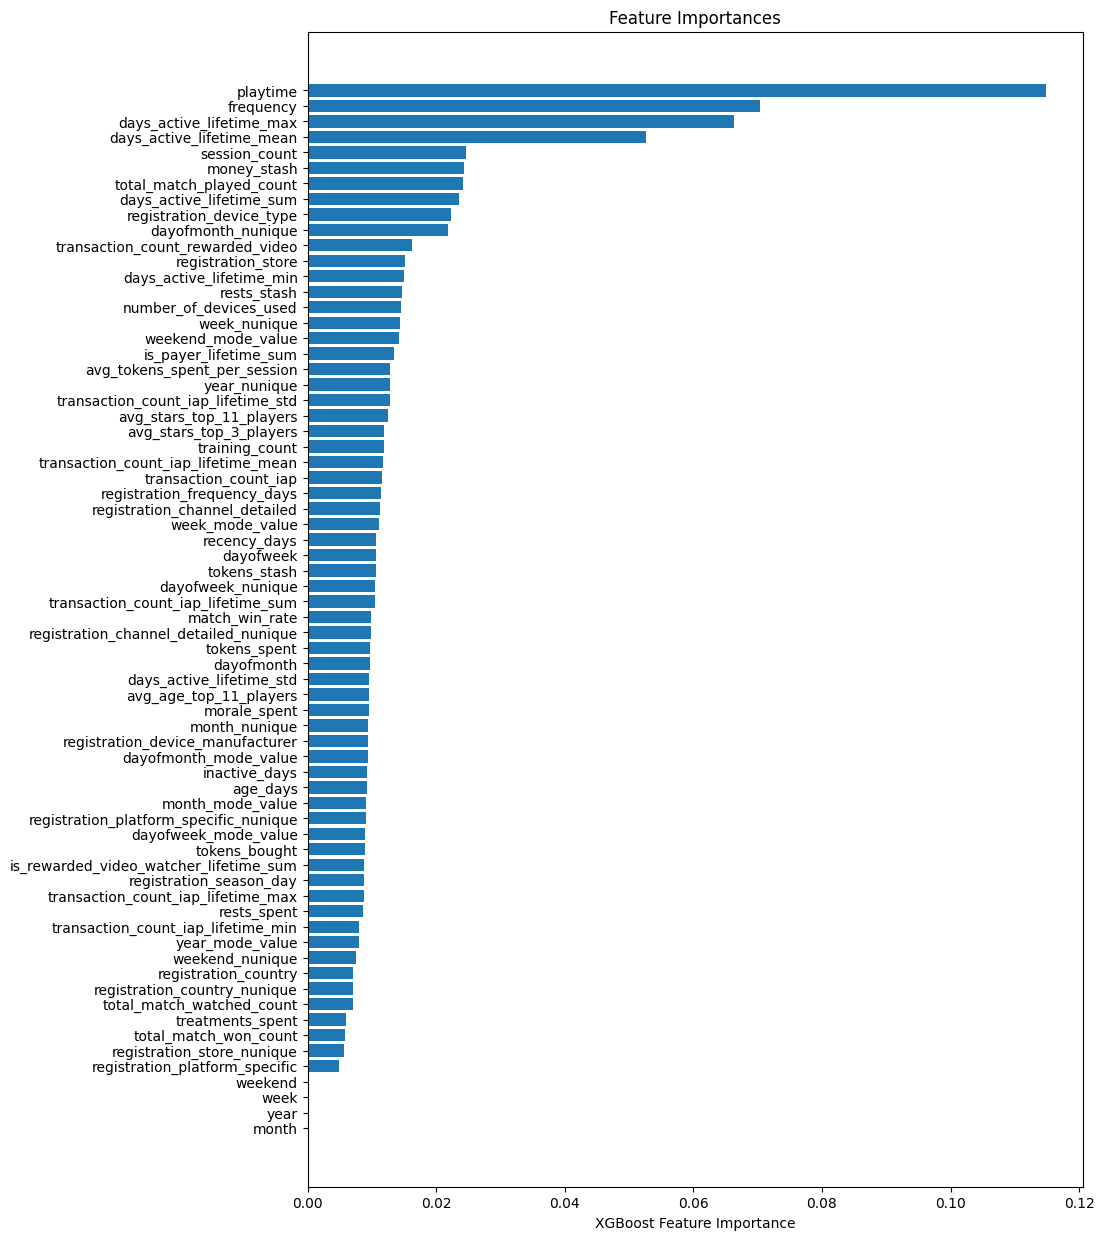

In [165]:
# train a xgboost regressor to select important features with tweedie objective
import xgboost as xgb

features = [
 f for f in df_merged_data_train.columns if f not in ("kfold", "days_active_first_28_days_after_registration")
 ]
model = xgb.XGBRegressor(
        n_jobs=-1,
        objective='reg:tweedie',
    )
model.fit(df_merged_data_train[features], df_merged_data_train['days_active_first_28_days_after_registration'])
importances = model.feature_importances_
plt.figure(figsize=(10, 15))
idxs = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [features[i] for i in idxs])
plt.xlabel('XGBoost Feature Importance')
plt.show()

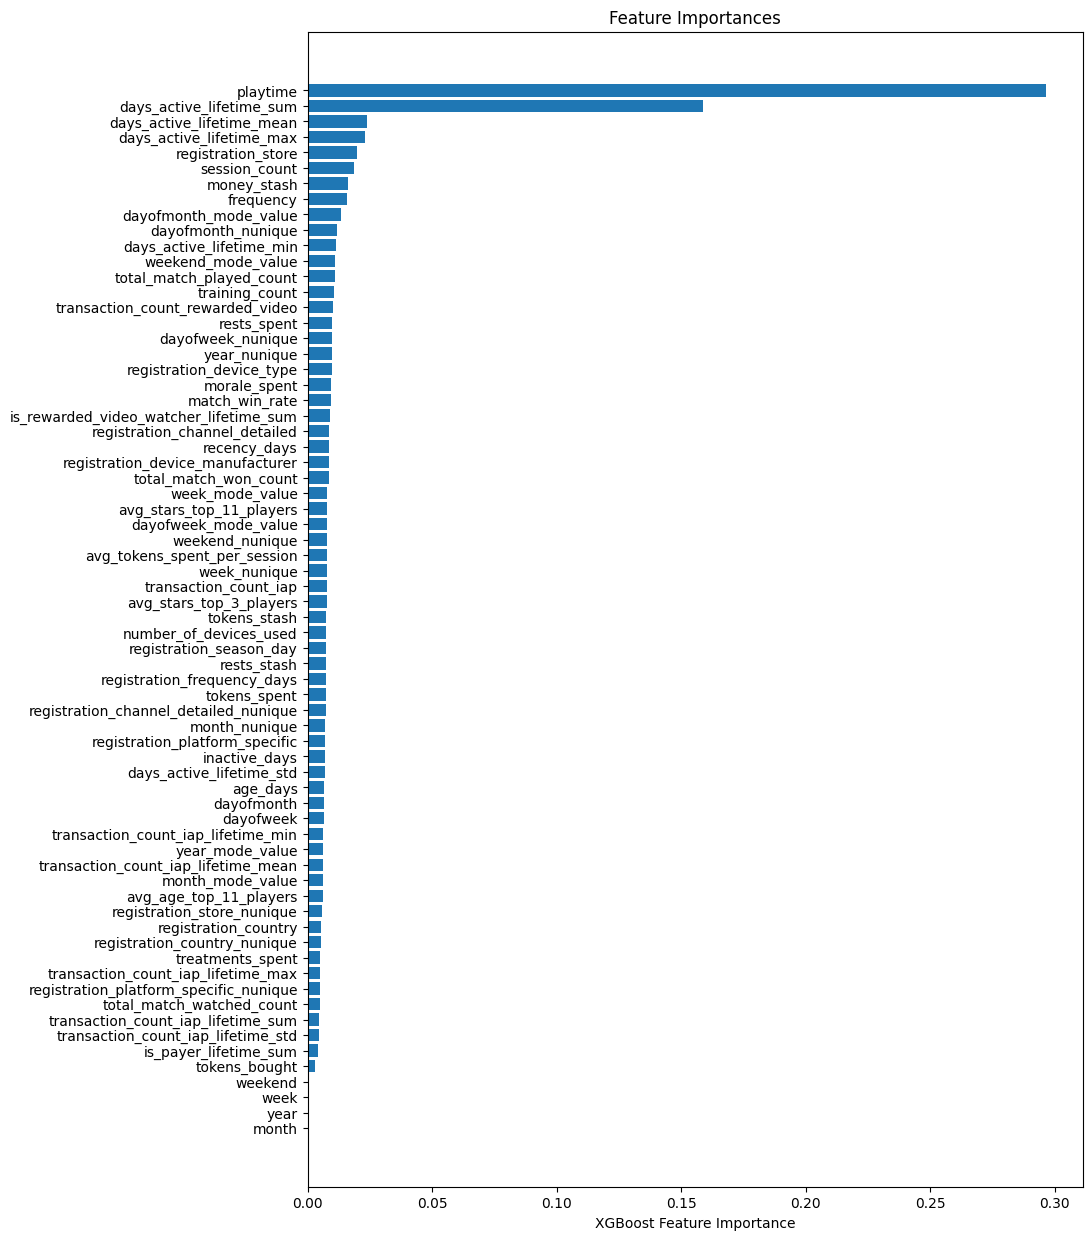

In [166]:
# select important features with absoluteerror objective
df_merged_data_train = pd.read_csv('/root/projects/ds_chlg/Data Science Challenge/Data Science/aggregated_data/merged_data_training.csv', index_col=0)
features = [
 f for f in df_merged_data_train.columns if f not in ("kfold", "days_active_first_28_days_after_registration")
 ]
model = xgb.XGBRegressor(
        n_jobs=-1,
        objective='reg:absoluteerror'
    )
model.fit(df_merged_data_train[features], df_merged_data_train['days_active_first_28_days_after_registration'])
importances = model.feature_importances_
plt.figure(figsize=(10, 15))
idxs = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [features[i] for i in idxs])
plt.xlabel('XGBoost Feature Importance')
plt.show()